Uncomment the lines below to disable GPU acceleration. Depending on your setup, this might speed up execution.

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ex5 import Pendulum, rbfprojector, Model, Memory
from time import time
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

help(Model)

Help on class Model in module ex5:

class Model(Network)
 |  Model(states, actions=1, hiddens=[25, 25])
 |  
 |  Deep learning-based dynamics model approximator.
 |  
 |  METHODS
 |      train       -- Train network on minibatch.
 |      fit         -- Fit network on memory.
 |      __call__    -- Evaluate network.
 |  
 |  Method resolution order:
 |      Model
 |      Network
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, s, a)
 |      Evaluates the dynamics approximator.
 |      
 |      r, sp = Model(s, a) returns the approximated reward `r` and next
 |      state `sp` at observation `s` and action `a`.
 |      
 |      `s` is either a vector specifying a single observation, or a
 |      matrix in which each row specifies one observation in a batch.
 |      `a` is the same size as the number of rows in `s`, and specifies
 |      the action at which to evaluate each observation in the batch.
 |      
 |      EXAMPLE
 |          >>> model = Model(2, 1,

## Exercise 1.1

This parameter sets the learning of the model to consider the diffence between the current state and next state, meaning that the values passed to the model are actually a relative value to the previous one.

This could improve learning, making it easier for the model to "understand" the behavior of the agent for an action, rather than the actual outcome of each action.

For example: pressing the acceleration pedal of a car will make it run faster. That would be the behavior, while the actual outcome would be the actual velocity it reaches when pressing its pedal in a certain position.

In [33]:
episodios = 100
use_model = True


lista_rewards = np.empty(episodios)
lista_rmse_r = np.empty(episodios)
lista_rmse_s_p = np.empty(episodios)

plt.ion()
plt.show()


start_time = time()


#Parameters

N = 30

camadas = [25,25]
gamma = 0.99
sigma = 1
batch_size = 256

nbasis = 21
width = 0.25
alpha = 0.2
beta = 0.01

phi = rbfprojector(nbasis, width)       #feature
theta = np.ones(len(phi([0,0,0])))*0.01 #actor
w = np.ones(len(phi([0,0,0])))*0.01     #critic


# Create environment
pendulum = Pendulum()

#create memory
memory = Memory(3,1)

#crate neural network model
model = Model(3,1,camadas)

#--------------------------Episodes start---------------------------------
for e in range(episodios):
    # Reset environment
    s = pendulum.reset()

    # reset do total reward
    total_reward = 0
    
    #creating empty arrays for model transitions
    model_r = []
    model_s_p = []
    step_r = []
    step_s_p = []
    
    #---------------------Time Step Start----------------------------------
    for t in range(1000):
        # Select action (exercise 2.2)

        a = np.random.normal(np.dot(phi(s), theta), sigma)

        # Step environment
        s_p, r, done, info = pendulum.step(a)
        step_r.append(r)
        step_s_p.append(s_p)
        
        #tracking transitions
        memory.add(s, a, r, s_p ,done)

        #acumulo total reward
        total_reward = total_reward + r

        delta = r + (gamma * np.dot(phi(s_p).T,w) - np.dot(phi(s).T,w))
        w = w + alpha * np.dot(delta, phi(s))
        theta = theta + beta*np.dot((a - np.dot(phi(s).T, theta)), np.dot(phi(s),delta))

        #Estimating reward and next_state with model
        mr, msp= model(s, a)
        model_r.append(mr)
        model_s_p.append(msp) 
        
        
        s = np.copy(s_p)


        # TODO: Render current state
#         if t%1 == 0:
#             pendulum.render()
        
    
        if done:
            break
    #---------------------Time Step Finish----------------------------------
    
    #training the enviroment model
    if e<20:
        model.fit(memory)
    else:
        if e%7==0:
            model.fit(memory)
    
    #RMSE for reward and next state
    rmse_r = sqrt(MSE(step_r, model_r))
    rmse_s_p = sqrt(MSE(step_s_p, model_s_p))
    
    print('RMSE reward: ' + str(rmse_r))
    print('RMSE next state: ' + str(rmse_s_p))
    
    lista_rmse_r[e] = rmse_r
    lista_rmse_s_p[e] = rmse_s_p
    
    
    sigma = sigma * 0.99
    if sigma < 0.05:
        sigma = 0.05
    
    
    lista_rewards[e] = total_reward
    print(str(e) + 'Episódio  ——>   total reward: ' + str(total_reward))

    
    end_time = time()
    computation_time = end_time - start_time
    
    rise_time = 0
    for ep in reversed(range(len(lista_rewards))):
        if lista_rewards[ep] < -500:
            ep = ep+2
            break
    rise_time = ep
    
    
    #---------------------Simulated Episodes Start----------------------------------
    # model has settled?
    if e > 10 and use_model:
        print('Simulated episodes!')
        for ep in range(N):
            s = pendulum.reset()

            for ts in range(20):
                # Select action (exercise 2.2)
                a = np.random.normal(np.dot(phi(s), theta), sigma)

                # Step simulated environment
                r, s_p = model(s, a)

                # normalizing the next state
                s_p = pendulum.normalize(s_p)

                #terminate early if variables exceed range
                if (s_p < pendulum.env.observation_space.low).any() or (s_p > pendulum.env.observation_space.high).any():
                    break

                #Updating actor-critic
                delta = r + (gamma * np.dot(phi(s_p).T,w) - np.dot(phi(s).T,w))
                w = w + alpha * np.dot(delta, phi(s))
                theta = theta + beta*np.dot((a - np.dot(phi(s).T, theta)), np.dot(phi(s),delta))
                
                #updating states
                s = np.copy(s_p)

    #---------------------Simulated Episodes Finish----------------------------------
    print()
    print()
    
#--------------------------Episodes finish---------------------------------


# Close environment
pendulum.close()



print('Computation time: ' + str(computation_time))
print('Rise time: ' + str(rise_time) + ' episodes')

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00556: early stopping
Model validation loss  0.00558127136901021
RMSE reward: 6.434202813072727
RMSE next state: 2.7241753288002113
0Episódio  ——>   total reward: -1085.1432307377997


Epoch 00174: early stopping
Model validation loss  0.0048126866834031215
RMSE reward: 0.3523392731345175
RMSE next state: 0.21076009131936035
1Episódio  ——>   total reward: -906.0658259790897


Epoch 00224: early stopping
Model validation loss  0.0033445872797596234
RMSE reward: 1.2707177073392146
RMSE next state: 0.18272088683636437
2Episódio  ——>   total reward: -1460.1540406704003


Epoch 00093: early stopping
Model validation loss  0.002439163356191582
RMSE reward: 0.16614302185343777
RMSE next state: 0.08395756312668519
3Episódio  ——>   total reward: -1222.0953574437624


Epoch 00070: early stopping
Model validation loss  0.002375620204127497
RMSE reward: 0.11651717150110445
RMSE next state: 0.04935849437728209
4Episódio  ——>   total reward: -1210.2453057727346


Epoch 00025: early stopping
Mo



RMSE reward: 0.02990956818216755
RMSE next state: 0.01667517431996694
47Episódio  ——>   total reward: -250.9672846144225
Simulated episodes!


RMSE reward: 0.019023836186498572
RMSE next state: 0.01166996320475499
48Episódio  ——>   total reward: -135.83406533293956
Simulated episodes!


Epoch 00024: early stopping
Model validation loss  0.0006563240955583751
RMSE reward: 0.03252018468819045
RMSE next state: 0.013824524578417168
49Episódio  ——>   total reward: -254.13189459522852
Simulated episodes!


RMSE reward: 0.013744523584558696
RMSE next state: 0.008783016515730598
50Episódio  ——>   total reward: -130.41831207239693
Simulated episodes!


RMSE reward: 0.01494660414820462
RMSE next state: 0.008714732765529306
51Episódio  ——>   total reward: -123.12881258540102
Simulated episodes!


RMSE reward: 0.017819397864955115
RMSE next state: 0.011804074327768595
52Episódio  ——>   total reward: -140.2281477253593
Simulated episodes!


RMSE reward: 0.017569169843990297
RMSE next state: 0.013



Computation time: 486.89577054977417
Rise time: 29 episodes


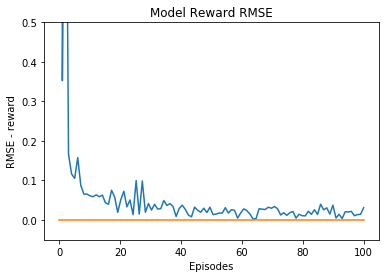

In [34]:
plt.title('Model Reward RMSE')
plt.xlabel('Episodes')
plt.ylabel('RMSE - reward')
plt.ylim(-0.05,0.5)
plt.plot(np.linspace(0,episodios,episodios), lista_rmse_r)
plt.plot(np.linspace(0,episodios,episodios), np.ones(episodios)*0)

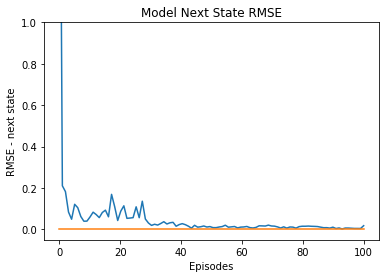

In [35]:
plt.title('Model Next State RMSE')
plt.xlabel('Episodes')
plt.ylabel('RMSE - next state')
plt.ylim(-0.05,1)
plt.plot(np.linspace(0,episodios,episodios), lista_rmse_s_p)
plt.plot(np.linspace(0,episodios,episodios), np.ones(episodios)*0)

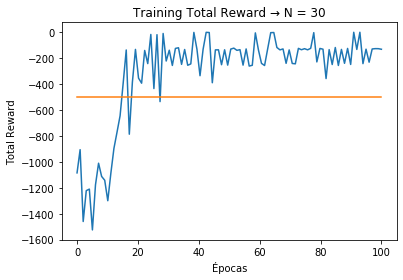

In [36]:
plt.title('Training Total Reward → N = ' + str(N))
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.plot(np.linspace(0,episodios,episodios), lista_rewards)
plt.plot(np.linspace(0,episodios,episodios), np.ones(episodios)*-500)

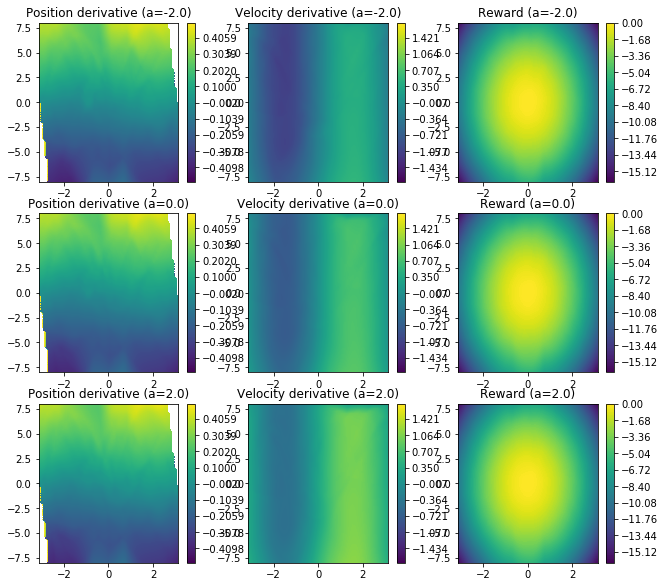

In [9]:
pendulum.plotnetwork(model)

# Exercice 2

## Exercise 2.2


RMSE plots from reward and next state:|     |
                                 :--- |:---:|
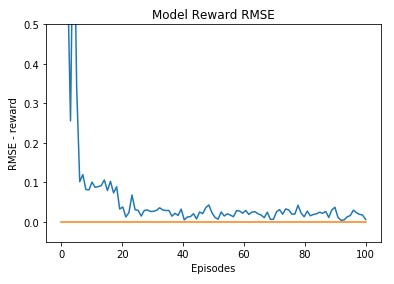|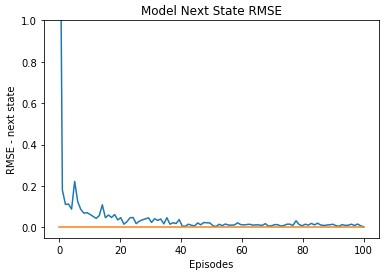||

---

Total Reward Plot (no simulated episodes used):                                     |     |
:---                                                                                |:---:|
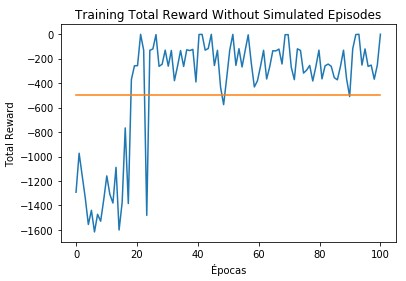|     |

---

Network Plot:                                                   |     |
:---                                                            |:---:|
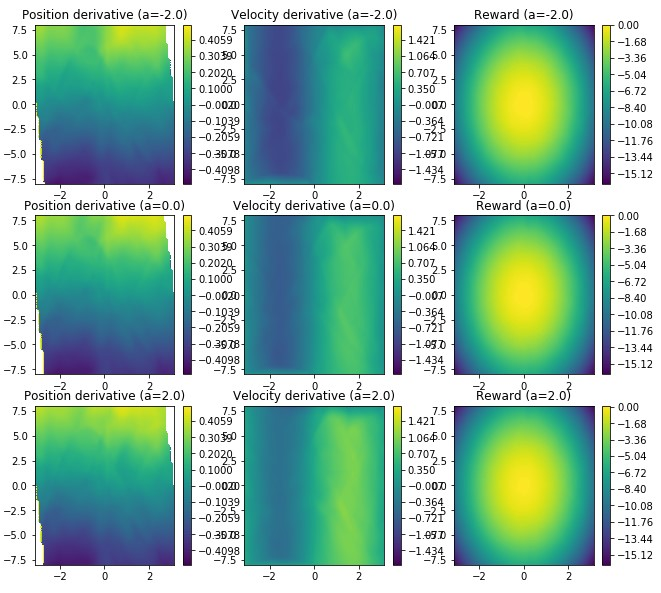|     |

---

Talking about the RMSE graphs, We see that only a few episodes after the start, The model achieves a root mean squared error that is lower than 0.2, for both next state and reward. It indicates that this environment is learned by our model with a good approximation with just these few episodes. Once our model is good enough to approximate the environment, we can start simulating episodes to improve learning with less real episodes.

Now, about the network plot, we see how the velocity (column 1), acceleration (column 2) and reward (column 3) behaves, when performin specific actions (-2, 0, 2). In this case, the first noticeable characteristic is that, despite changing the action, all graphs are still mostly the same. We can see a slightly difference in the first column: when we take action 2, the graph is more yellowish, so we have more positive velocities. A similar behavior can be seen in the second column, showing that when we take action 2, the average acceleration is more positive, and when taking a negative action, we see a darker graph, meaning that the average acceleration is more negative (or lower). The third column tells how the reward is achieved through position and velocity, being a position 0 (up) and velocity 0 the most reward we can get.

## Exercise 2.4 - code

In [28]:
rodadas = 10

runs_total_reward = []
runs_rise_time = []
runs_computation_time = []
runs_end_performance = []

full_start_time = time()

for run in range(rodadas):
    episodios = 100
    use_model = True


    lista_rewards = np.empty(episodios)
    lista_rmse_r = np.empty(episodios)
    lista_rmse_s_p = np.empty(episodios)

    plt.ion()
    plt.show()
    
    
    print('----------------- Iniciating Training -----------------')
    training_start_time = time()


    #Parameters

    N = 30

    camadas = [25,25]
    gamma = 0.99
    sigma = 1
    batch_size = 256

    nbasis = 21
    width = 0.25
    alpha = 0.2
    beta = 0.01

    phi = rbfprojector(nbasis, width)       #feature
    theta = np.ones(len(phi([0,0,0])))*0.01 #actor
    w = np.ones(len(phi([0,0,0])))*0.01     #critic


    # Create environment
    pendulum = Pendulum()

    #create memory
    memory = Memory(3,1)

    #crate neural network model
    model = Model(3,1,camadas)

    #--------------------------Episodes start---------------------------------
    for e in range(episodios):
        # Reset environment
        s = pendulum.reset()

        # reset do total reward
        total_reward = 0

        #creating empty arrays for model transitions
        model_r = []
        model_s_p = []
        step_r = []
        step_s_p = []

        #---------------------Time Step Start----------------------------------
        for t in range(1000):
            # Select action (exercise 2.2)

            a = np.random.normal(np.dot(phi(s), theta), sigma)

            # Step environment
            s_p, r, done, info = pendulum.step(a)
            step_r.append(r)
            step_s_p.append(s_p)

            #tracking transitions
            memory.add(s, a, r, s_p ,done)

            #acumulo total reward
            total_reward = total_reward + r

            delta = r + (gamma * np.dot(phi(s_p).T,w) - np.dot(phi(s).T,w))
            w = w + alpha * np.dot(delta, phi(s))
            theta = theta + beta*np.dot((a - np.dot(phi(s).T, theta)), np.dot(phi(s),delta))

            #Estimating reward and next_state with model
            mr, msp= model(s, a)
            model_r.append(mr)
            model_s_p.append(msp) 


            s = np.copy(s_p)


            # TODO: Render current state
    #         if t%1 == 0:
    #             pendulum.render()


            if done:
                break
        #---------------------Time Step Finish----------------------------------

        #training the enviroment model
        if e<20:
            model.fit(memory)
        else:
            if e%7==0:
                model.fit(memory)

        #RMSE for reward and next state
        rmse_r = sqrt(MSE(step_r, model_r))
        rmse_s_p = sqrt(MSE(step_s_p, model_s_p))

        print('RMSE reward: ' + str(rmse_r))
        print('RMSE next state: ' + str(rmse_s_p))

        lista_rmse_r[e] = rmse_r
        lista_rmse_s_p[e] = rmse_s_p


        sigma = sigma * 0.99
        if sigma < 0.05:
            sigma = 0.05


        lista_rewards[e] = total_reward
        print(str(e) + 'Episódio  ——>   total reward: ' + str(total_reward))


        #---------------------Simulated Episodes Start----------------------------------
        # model has settled?
        if e > 10 and use_model:
            print('Simulated episodes!')
            for ep in range(N):
                s = pendulum.reset()

                for ts in range(20):
                    # Select action (exercise 2.2)
                    a = np.random.normal(np.dot(phi(s), theta), sigma)

                    # Step simulated environment
                    r, s_p = model(s, a)

                    # normalizing the next state
                    s_p = pendulum.normalize(s_p)

                    #terminate early if variables exceed range
                    if (s_p < pendulum.env.observation_space.low).any() or (s_p > pendulum.env.observation_space.high).any():
                        break

                    #Updating actor-critic
                    delta = r + (gamma * np.dot(phi(s_p).T,w) - np.dot(phi(s).T,w))
                    w = w + alpha * np.dot(delta, phi(s))
                    theta = theta + beta*np.dot((a - np.dot(phi(s).T, theta)), np.dot(phi(s),delta))

                    #updating states
                    s = np.copy(s_p)

        #---------------------Simulated Episodes Finish----------------------------------
        
        training_end_time = time()
        training_computation_time = training_end_time - training_start_time

        rise_time = 0
        for ep in reversed(range(len(lista_rewards))):
            if lista_rewards[ep] < -500:
                ep = ep+2
                break
        rise_time = ep
        
        print()
        print()

    #--------------------------Episodes finish---------------------------------

    # Close environment
    pendulum.close()

    print('Computation time: ' + str(training_computation_time))
    print('Rise time: ' + str(rise_time) + ' episodes')
    
    runs_computation_time.append(training_computation_time)
    runs_total_reward.append(lista_rewards)
    runs_rise_time.append(rise_time)
    
    #================================ Start Evaluation ================================
    
    
    print('-----------------Iniciating Evaluation-----------------')
    episodios = 100

    lista_rewards = np.empty(episodios)

    #Parameters
    sigma = 0

    #--------------------------Episodes start---------------------------------
    for e in range(episodios):
        # Reset environment
        s = pendulum.reset()

        # reset do total reward
        total_reward = 0

        #---------------------Time Step Start----------------------------------
        for t in range(1000):
            # Select action
            a = np.random.normal(np.dot(phi(s), theta), sigma)

            # Step environment
            s_p, r, done, info = pendulum.step(a)

            #acumulo total reward
            total_reward = total_reward + r

            s = np.copy(s_p)

            if done:
                break
        #---------------------Time Step Finish----------------------------------
        lista_rewards[e] = total_reward
        print(str(e) + 'Episódio  ——>   total reward: ' + str(total_reward))

        rise_time = 0
        for ep in reversed(range(len(lista_rewards))):
            if lista_rewards[ep] < -500:
                ep = ep+2
                break
        rise_time = ep
        #--------------------------Episodes finish---------------------------------
    #================================ Finish Evaluation ================================
    
    runs_end_performance.append(np.mean(lista_rewards))
    
    # Close environment
    pendulum.close()
    
    print('End performance: ' + str(runs_end_performance[run]))

full_end_time = time()    
full_computation_time = full_end_time - full_start_time
print('Full Computation time: ' + str(full_computation_time))

         

----------------- Iniciating Training -----------------


C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00474: early stopping
Model validation loss  0.016794300783011647
RMSE reward: 5.6683787172225415
RMSE next state: 2.36914276542239
0Episódio  ——>   total reward: -1071.5854927481168


Epoch 00200: early stopping
Model validation loss  0.006386806432985597
RMSE reward: 1.2469241970108318
RMSE next state: 0.18495941233954347
1Episódio  ——>   total reward: -1539.1244665270779


Epoch 00079: early stopping
Model validation loss  0.004221820629512271
RMSE reward: 0.15099726444017955
RMSE next state: 0.043239581202403614
2Episódio  ——>   total reward: -1314.9933358280066


Epoch 00047: early stopping
Model validation loss  0.0036028732493933705
RMSE reward: 0.13463810932610945
RMSE next state: 0.054899598286440844
3Episódio  ——>   total reward: -1065.4487606434798


Epoch 00110: early stopping
Model validation loss  0.0036385783496209315
RMSE reward: 0.5968352835820012
RMSE next state: 0.12537516423402503
4Episódio  ——>   total reward: -1048.4395415272859


Epoch 00051: early stopping



RMSE reward: 0.027187825480586382
RMSE next state: 0.020154681909172134
47Episódio  ——>   total reward: -148.36157107484914
Simulated episodes!


RMSE reward: 0.04724653957170916
RMSE next state: 0.029594888097530306
48Episódio  ——>   total reward: -274.68931987909485
Simulated episodes!


Epoch 00071: early stopping
Model validation loss  0.0010379718900140789
RMSE reward: 0.03884478576446283
RMSE next state: 0.023415301722182192
49Episódio  ——>   total reward: -147.84935350452173
Simulated episodes!


RMSE reward: 0.03487445734102456
RMSE next state: 0.023061926492796883
50Episódio  ——>   total reward: -400.14215737866806
Simulated episodes!


RMSE reward: 0.03512258021373136
RMSE next state: 0.02979705934472526
51Episódio  ——>   total reward: -393.30978652918213
Simulated episodes!


RMSE reward: 0.030417677563452317
RMSE next state: 0.016894137129085773
52Episódio  ——>   total reward: -263.36843786359765
Simulated episodes!


RMSE reward: 0.033720704104070284
RMSE next state: 0.0



Computation time: 655.4177134037018
Rise time: 30 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -120.37585411866937
1Episódio  ——>   total reward: -130.2362530173002
2Episódio  ——>   total reward: -1.2180348680119024
3Episódio  ——>   total reward: -121.64666860344676
4Episódio  ——>   total reward: -243.83033798966468
5Episódio  ——>   total reward: -126.6966913446661
6Episódio  ——>   total reward: -128.08863431007876
7Episódio  ——>   total reward: -1.7096926060697648
8Episódio  ——>   total reward: -1.388146785508288
9Episódio  ——>   total reward: -127.26133344816662
10Episódio  ——>   total reward: -128.35437562957924
11Episódio  ——>   total reward: -126.8847385156306
12Episódio  ——>   total reward: -239.44654637844903
13Episódio  ——>   total reward: -130.68875979531606
14Episódio  ——>   total reward: -127.13836376629243
15Episódio  ——>   total reward: -119.13256175452723
16Episódio  ——>   total reward: -245.59637964648985
17Episódio  —

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00302: early stopping
Model validation loss  0.01788657700849904
RMSE reward: 6.2089942997805405
RMSE next state: 2.330049559802224
0Episódio  ——>   total reward: -1064.2737149618308


Epoch 00228: early stopping
Model validation loss  0.0042211595094866225
RMSE reward: 1.28102150752901
RMSE next state: 0.17523561238114063
1Episódio  ——>   total reward: -1401.4546145824265


Epoch 00268: early stopping
Model validation loss  0.004653185357650121
RMSE reward: 0.7916558921051993
RMSE next state: 0.10689239006017148
2Episódio  ——>   total reward: -1151.9096577279793


Epoch 00050: early stopping
Model validation loss  0.0051993625548978645
RMSE reward: 0.26386921596030083
RMSE next state: 0.15047994477021057
3Episódio  ——>   total reward: -1177.3477283313082


Epoch 00068: early stopping
Model validation loss  0.0042543166068693
RMSE reward: 0.13411242192894923
RMSE next state: 0.08262843908086903
4Episódio  ——>   total reward: -1234.8352706126852


Epoch 00068: early stopping
Model



RMSE reward: 0.026381932808836907
RMSE next state: 0.015291757005865552
47Episódio  ——>   total reward: -133.1974866859452
Simulated episodes!


RMSE reward: 0.043153101102672294
RMSE next state: 0.028220900782844355
48Episódio  ——>   total reward: -269.57122483292625
Simulated episodes!


Epoch 00078: early stopping
Model validation loss  0.0014111618050891492
RMSE reward: 0.008826066419267201
RMSE next state: 0.006978234485459175
49Episódio  ——>   total reward: -3.145920533448642
Simulated episodes!


RMSE reward: 0.04677682626647787
RMSE next state: 0.022134601941515508
50Episódio  ——>   total reward: -134.52733397218796
Simulated episodes!


RMSE reward: 0.02908301645916223
RMSE next state: 0.023889532572491066
51Episódio  ——>   total reward: -125.4102610769155
Simulated episodes!


RMSE reward: 0.051160140985987174
RMSE next state: 0.022734029852611897
52Episódio  ——>   total reward: -142.80485544300416
Simulated episodes!


RMSE reward: 0.0625884337100411
RMSE next state: 0.026



Computation time: 891.6490721702576
Rise time: 101 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -520.8747861970254
1Episódio  ——>   total reward: -530.0024619244562
2Episódio  ——>   total reward: -642.3238456974786
3Episódio  ——>   total reward: -519.8126980096835
4Episódio  ——>   total reward: -521.2397009858402
5Episódio  ——>   total reward: -474.00785848434265
6Episódio  ——>   total reward: -551.3737650137338
7Episódio  ——>   total reward: -514.2074681184517
8Episódio  ——>   total reward: -527.6440349083422
9Episódio  ——>   total reward: -696.0774255541254
10Episódio  ——>   total reward: -529.7562453300701
11Episódio  ——>   total reward: -629.1179517729161
12Episódio  ——>   total reward: -531.9457391193966
13Episódio  ——>   total reward: -521.8209874628889
14Episódio  ——>   total reward: -519.7683052460908
15Episódio  ——>   total reward: -596.6048571272565
16Episódio  ——>   total reward: -516.9963644458564
17Episódio  ——>   total 

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00687: early stopping
Model validation loss  0.0038362280362182195
RMSE reward: 6.194017880201028
RMSE next state: 2.1734757229494264
0Episódio  ——>   total reward: -1202.987846483893


Epoch 00124: early stopping
Model validation loss  0.004560770860148801
RMSE reward: 0.5122996558128717
RMSE next state: 0.12467144036179696
1Episódio  ——>   total reward: -997.8128188356632


Epoch 00133: early stopping
Model validation loss  0.0032778387026930296
RMSE reward: 0.5612808244228249
RMSE next state: 0.09530882353246549
2Episódio  ——>   total reward: -1201.8115156291594


Epoch 00065: early stopping
Model validation loss  0.00340607769580351
RMSE reward: 0.5948805567883874
RMSE next state: 0.09847450840958416
3Episódio  ——>   total reward: -1139.2882621260296


Epoch 00036: early stopping
Model validation loss  0.004200249498503075
RMSE reward: 0.09857056523675996
RMSE next state: 0.08928011262340456
4Episódio  ——>   total reward: -1263.602708747395


Epoch 00021: early stopping
Model



RMSE reward: 0.023547143010918894
RMSE next state: 0.014425721908131031
47Episódio  ——>   total reward: -131.80468873072016
Simulated episodes!


RMSE reward: 0.031176076431143694
RMSE next state: 0.01822967537646906
48Episódio  ——>   total reward: -246.05581724639916
Simulated episodes!


Epoch 00068: early stopping
Model validation loss  0.0005639654416073527
RMSE reward: 0.024951974699116353
RMSE next state: 0.01555184578914132
49Episódio  ——>   total reward: -128.39806337091824
Simulated episodes!


RMSE reward: 0.057269420777102974
RMSE next state: 0.014413371077564468
50Episódio  ——>   total reward: -238.84243623243506
Simulated episodes!


RMSE reward: 0.02309627585958551
RMSE next state: 0.014086434965469307
51Episódio  ——>   total reward: -124.35178676585099
Simulated episodes!


RMSE reward: 0.009004494915118743
RMSE next state: 0.008998203051404972
52Episódio  ——>   total reward: -6.830484934245841
Simulated episodes!


RMSE reward: 0.02204937444044252
RMSE next state: 0.0



Computation time: 728.1771502494812
Rise time: 13 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -132.65315739671573
1Episódio  ——>   total reward: -129.6149257454142
2Episódio  ——>   total reward: -233.16568670292037
3Episódio  ——>   total reward: -121.2617613746015
4Episódio  ——>   total reward: -118.54546342739714
5Episódio  ——>   total reward: -235.72633023750308
6Episódio  ——>   total reward: -117.26945718268902
7Episódio  ——>   total reward: -128.4032151597132
8Episódio  ——>   total reward: -358.8514235577716
9Episódio  ——>   total reward: -238.3464294790104
10Episódio  ——>   total reward: -130.34099542570004
11Episódio  ——>   total reward: -118.63741454703633
12Episódio  ——>   total reward: -1.1447327835852108
13Episódio  ——>   total reward: -125.20663503007157
14Episódio  ——>   total reward: -135.7144321122103
15Episódio  ——>   total reward: -134.40757251029865
16Episódio  ——>   total reward: -115.67071534499439
17Episódio  ——>

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00381: early stopping
Model validation loss  0.020836280865801707
RMSE reward: 6.632134614452515
RMSE next state: 2.6272759540417074
0Episódio  ——>   total reward: -978.5125303882935


Epoch 00445: early stopping
Model validation loss  0.004070009912053744
RMSE reward: 0.9176897313516096
RMSE next state: 0.2148127729046114
1Episódio  ——>   total reward: -1359.2312282788644


Epoch 00196: early stopping
Model validation loss  0.0018497356334356246
RMSE reward: 0.4808509990756267
RMSE next state: 0.05370877522749199
2Episódio  ——>   total reward: -1597.2479335031953


Epoch 00043: early stopping
Model validation loss  0.002234861549610893
RMSE reward: 0.11533226299387836
RMSE next state: 0.040130053426625935
3Episódio  ——>   total reward: -1078.9554463061463


Epoch 00042: early stopping
Model validation loss  0.0029869176571567855
RMSE reward: 0.10305614955595566
RMSE next state: 0.09373557655677553
4Episódio  ——>   total reward: -1127.6417449928133


Epoch 00037: early stopping
M



RMSE reward: 0.026300518192332825
RMSE next state: 0.02167404115377932
47Episódio  ——>   total reward: -115.55111153478866
Simulated episodes!


RMSE reward: 0.023411783661388637
RMSE next state: 0.02297594464329725
48Episódio  ——>   total reward: -127.9648567820005
Simulated episodes!


Epoch 00044: early stopping
Model validation loss  0.0013443871641324627
RMSE reward: 0.026519717456210214
RMSE next state: 0.02203160314151691
49Episódio  ——>   total reward: -118.79589938405229
Simulated episodes!


RMSE reward: 0.01848989341521674
RMSE next state: 0.01650592946440932
50Episódio  ——>   total reward: -132.20288308320102
Simulated episodes!


RMSE reward: 0.01719493128182422
RMSE next state: 0.01752601833072862
51Episódio  ——>   total reward: -130.72445018478558
Simulated episodes!


RMSE reward: 0.021585253442756115
RMSE next state: 0.01737585393355141
52Episódio  ——>   total reward: -115.46273175219979
Simulated episodes!


RMSE reward: 0.08884116167736622
RMSE next state: 0.028439



Computation time: 855.8260040283203
Rise time: 26 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -1.300243315134663
1Episódio  ——>   total reward: -126.32557464050316
2Episódio  ——>   total reward: -125.84843193022823
3Episódio  ——>   total reward: -116.70219576696441
4Episódio  ——>   total reward: -121.97401353587564
5Episódio  ——>   total reward: -119.26914290348849
6Episódio  ——>   total reward: -121.04661376887125
7Episódio  ——>   total reward: -120.1646120812889
8Episódio  ——>   total reward: -118.45534948392411
9Episódio  ——>   total reward: -129.24118750117484
10Episódio  ——>   total reward: -239.49575007014414
11Episódio  ——>   total reward: -114.491834965141
12Episódio  ——>   total reward: -227.3557595404251
13Episódio  ——>   total reward: -131.52895601253294
14Episódio  ——>   total reward: -114.31230799880375
15Episódio  ——>   total reward: -122.40713186814506
16Episódio  ——>   total reward: -119.51456935392947
17Episódio  ——

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00457: early stopping
Model validation loss  0.017184921188486947
RMSE reward: 7.201612019270039
RMSE next state: 2.128908995474527
0Episódio  ——>   total reward: -1307.7581424885198


Epoch 00338: early stopping
Model validation loss  0.004417202601002322
RMSE reward: 0.5758336354522465
RMSE next state: 0.16965983261298245
1Episódio  ——>   total reward: -1049.379699367225


Epoch 00099: early stopping
Model validation loss  0.003069052946995254
RMSE reward: 0.24938851780738305
RMSE next state: 0.08677982842903387
2Episódio  ——>   total reward: -974.6311812723372


Epoch 00080: early stopping
Model validation loss  0.0027507954716889395
RMSE reward: 0.14504505334881576
RMSE next state: 0.0635103425377346
3Episódio  ——>   total reward: -1056.6595048977154


Epoch 00071: early stopping
Model validation loss  0.0036256016542514165
RMSE reward: 0.29273191074518606
RMSE next state: 0.16017575866797762
4Episódio  ——>   total reward: -1201.8551049033413


Epoch 00030: early stopping
Mod



RMSE reward: 0.08385496688163976
RMSE next state: 0.02150773754155692
47Episódio  ——>   total reward: -254.68805254726195
Simulated episodes!


RMSE reward: 0.11796256375903666
RMSE next state: 0.02370820215041333
48Episódio  ——>   total reward: -346.83294809492327
Simulated episodes!


Epoch 00022: early stopping
Model validation loss  0.0007662861799924738
RMSE reward: 0.031828077515372345
RMSE next state: 0.022752563227255683
49Episódio  ——>   total reward: -133.72661825207
Simulated episodes!


RMSE reward: 0.01662454925511431
RMSE next state: 0.011659093464747727
50Episódio  ——>   total reward: -132.30176721615098
Simulated episodes!


RMSE reward: 0.03430227408740706
RMSE next state: 0.00930971222949426
51Episódio  ——>   total reward: -124.63725229645239
Simulated episodes!


RMSE reward: 0.03710257990881661
RMSE next state: 0.015715117602921064
52Episódio  ——>   total reward: -248.8547554662789
Simulated episodes!


RMSE reward: 0.016068022801642344
RMSE next state: 0.01180608



Computation time: 631.6403906345367
Rise time: 18 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -129.50611962864681
1Episódio  ——>   total reward: -1.2812435713780594
2Episódio  ——>   total reward: -240.04253768818
3Episódio  ——>   total reward: -115.72229621750382
4Episódio  ——>   total reward: -121.33380788998227
5Episódio  ——>   total reward: -2.702481682620391
6Episódio  ——>   total reward: -266.00679564740875
7Episódio  ——>   total reward: -131.02163539672708
8Episódio  ——>   total reward: -128.01890987378948
9Episódio  ——>   total reward: -131.2920523772701
10Episódio  ——>   total reward: -5.547545580925622
11Episódio  ——>   total reward: -132.21281688341566
12Episódio  ——>   total reward: -228.5071092370644
13Episódio  ——>   total reward: -255.8930032212318
14Episódio  ——>   total reward: -133.47999553391566
15Episódio  ——>   total reward: -120.23931854990506
16Episódio  ——>   total reward: -132.41528927360488
17Episódio  ——>  

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00589: early stopping
Model validation loss  0.007213847277065118
RMSE reward: 6.593441989167431
RMSE next state: 1.8096564045876753
0Episódio  ——>   total reward: -1309.9641495035476


Epoch 00112: early stopping
Model validation loss  0.006609474960714579
RMSE reward: 0.3878385987689611
RMSE next state: 0.15371409332474303
1Episódio  ——>   total reward: -1018.0065680462394


Epoch 00126: early stopping
Model validation loss  0.004573945145778082
RMSE reward: 0.23277247348538357
RMSE next state: 0.0823329167129587
2Episódio  ——>   total reward: -1145.0494073877442


Epoch 00219: early stopping
Model validation loss  0.002318593171528644
RMSE reward: 0.48658852671899383
RMSE next state: 0.08324494225246329
3Episódio  ——>   total reward: -1307.8214587016278


Epoch 00124: early stopping
Model validation loss  0.002665562532428238
RMSE reward: 0.44364187886917844
RMSE next state: 0.14225768406433573
4Episódio  ——>   total reward: -1043.5464879358103


Epoch 00035: early stopping
Mo



RMSE reward: 0.03222552276284605
RMSE next state: 0.01409912897472808
47Episódio  ——>   total reward: -262.68813733659437
Simulated episodes!


RMSE reward: 0.019403504452315506
RMSE next state: 0.011032727792497522
48Episódio  ——>   total reward: -118.75231381764495
Simulated episodes!


Epoch 00022: early stopping
Model validation loss  0.0005612170285183109
RMSE reward: 0.005048733870113477
RMSE next state: 0.007053309535285784
49Episódio  ——>   total reward: -0.7042388362493989
Simulated episodes!


RMSE reward: 0.02206723871148654
RMSE next state: 0.010790036832195241
50Episódio  ——>   total reward: -127.5150310319635
Simulated episodes!


RMSE reward: 0.037601436094698584
RMSE next state: 0.01567519964374384
51Episódio  ——>   total reward: -233.5054956560724
Simulated episodes!


RMSE reward: 0.012057849964338025
RMSE next state: 0.007212318992749923
52Episódio  ——>   total reward: -1.6780881202582392
Simulated episodes!


RMSE reward: 0.02322931612630275
RMSE next state: 0.012



Computation time: 711.8374698162079
Rise time: 24 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -131.21219015911987
1Episódio  ——>   total reward: -228.72912224650094
2Episódio  ——>   total reward: -137.28211635815387
3Episódio  ——>   total reward: -131.91160459521262
4Episódio  ——>   total reward: -136.34532126786937
5Episódio  ——>   total reward: -131.7611158692273
6Episódio  ——>   total reward: -238.34860531431622
7Episódio  ——>   total reward: -124.78272738430532
8Episódio  ——>   total reward: -129.3845734301135
9Episódio  ——>   total reward: -126.12102384306287
10Episódio  ——>   total reward: -257.10225228585426
11Episódio  ——>   total reward: -132.3917548931198
12Episódio  ——>   total reward: -125.26279481709989
13Episódio  ——>   total reward: -133.30526539646615
14Episódio  ——>   total reward: -131.80654026456034
15Episódio  ——>   total reward: -253.33767443288008
16Episódio  ——>   total reward: -306.71933745048426
17Episódio  

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00375: early stopping
Model validation loss  0.017694822698831558
RMSE reward: 6.596378348307452
RMSE next state: 3.384616560092968
0Episódio  ——>   total reward: -883.3262873419457


Epoch 00092: early stopping
Model validation loss  0.02326431075731913
RMSE reward: 0.6574650235195211
RMSE next state: 0.21093704477875494
1Episódio  ——>   total reward: -1178.5039467273816


Epoch 00305: early stopping
Model validation loss  0.006720597973024403
RMSE reward: 0.991360445859339
RMSE next state: 0.15359743964146472
2Episódio  ——>   total reward: -1504.5015073026748


Epoch 00029: early stopping
Model validation loss  0.004959420828769604
RMSE reward: 0.15529900341182654
RMSE next state: 0.04850750872199619
3Episódio  ——>   total reward: -1207.084168963573


Epoch 00124: early stopping
Model validation loss  0.0053816939414375355
RMSE reward: 0.19852425272593793
RMSE next state: 0.06522223291297051
4Episódio  ——>   total reward: -971.6298239049952


Epoch 00039: early stopping
Model v



RMSE reward: 0.0197798253359584
RMSE next state: 0.019342223011859724
47Episódio  ——>   total reward: -123.43979347178463
Simulated episodes!


RMSE reward: 0.01855758182235588
RMSE next state: 0.021406031926698012
48Episódio  ——>   total reward: -127.73901311415162
Simulated episodes!


Epoch 00033: early stopping
Model validation loss  0.0011164169182949183
RMSE reward: 0.02483779179584765
RMSE next state: 0.018798013529870945
49Episódio  ——>   total reward: -129.18822135938188
Simulated episodes!


RMSE reward: 0.03065486701922112
RMSE next state: 0.019814465754328645
50Episódio  ——>   total reward: -121.0366686419817
Simulated episodes!


RMSE reward: 0.039833880556680565
RMSE next state: 0.01611296033361725
51Episódio  ——>   total reward: -240.55799630748623
Simulated episodes!


RMSE reward: 0.017867596576223607
RMSE next state: 0.013225180677201069
52Episódio  ——>   total reward: -124.77357042258171
Simulated episodes!


RMSE reward: 0.016106937159841565
RMSE next state: 0.013



Computation time: 831.7771427631378
Rise time: 67 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -12.675226599720398
1Episódio  ——>   total reward: -136.9451644480406
2Episódio  ——>   total reward: -128.9177496839786
3Episódio  ——>   total reward: -11.80568586268573
4Episódio  ——>   total reward: -137.8771698061254
5Episódio  ——>   total reward: -11.756242660877952
6Episódio  ——>   total reward: -14.222668388212215
7Episódio  ——>   total reward: -140.29847053725337
8Episódio  ——>   total reward: -261.0272580703324
9Episódio  ——>   total reward: -138.20329308006842
10Episódio  ——>   total reward: -11.860395818118903
11Episódio  ——>   total reward: -130.77518367760516
12Episódio  ——>   total reward: -270.16045654830157
13Episódio  ——>   total reward: -258.69237539582883
14Episódio  ——>   total reward: -245.66314288367354
15Episódio  ——>   total reward: -374.56801820259074
16Episódio  ——>   total reward: -235.99877728803816
17Episódio  ——

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00910: early stopping
Model validation loss  0.0014503722234318654
RMSE reward: 7.908949712925636
RMSE next state: 2.0760328756219737
0Episódio  ——>   total reward: -1345.7625294273423


Epoch 00072: early stopping
Model validation loss  0.0017849092164801228
RMSE reward: 0.17241939096669867
RMSE next state: 0.047216496493182346
1Episódio  ——>   total reward: -1574.0118067977253


Epoch 00301: early stopping
Model validation loss  0.001313176933089616
RMSE reward: 0.5057412087766946
RMSE next state: 0.24866971439829777
2Episódio  ——>   total reward: -1088.1901299466235


Epoch 00179: early stopping
Model validation loss  0.0022182258415139383
RMSE reward: 0.565820070141598
RMSE next state: 0.11821361891011119
3Episódio  ——>   total reward: -1044.7747109021147


Epoch 00080: early stopping
Model validation loss  0.002878013090489225
RMSE reward: 0.3827468585452485
RMSE next state: 0.0788329593394959
4Episódio  ——>   total reward: -1158.1607398704052


Epoch 00055: early stopping
M



RMSE reward: 0.009130855312891288
RMSE next state: 0.003926895947951807
47Episódio  ——>   total reward: -4.426393440026917
Simulated episodes!


RMSE reward: 0.026838694580571393
RMSE next state: 0.010655750671280833
48Episódio  ——>   total reward: -132.40328628355144
Simulated episodes!


Epoch 00021: early stopping
Model validation loss  0.0006992515641161138
RMSE reward: 0.02120900664784674
RMSE next state: 0.01129761790985522
49Episódio  ——>   total reward: -121.73708343035149
Simulated episodes!


RMSE reward: 0.022436380764037565
RMSE next state: 0.017114520598234657
50Episódio  ——>   total reward: -134.3072323787489
Simulated episodes!


RMSE reward: 0.035555691162505856
RMSE next state: 0.024994819959039485
51Episódio  ——>   total reward: -245.28309509918466
Simulated episodes!


RMSE reward: 0.02115072900965956
RMSE next state: 0.01887189437980462
52Episódio  ——>   total reward: -126.33885486893251
Simulated episodes!


RMSE reward: 0.02374906384639552
RMSE next state: 0.020



Computation time: 674.6510314941406
Rise time: 17 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -121.16038790842715
1Episódio  ——>   total reward: -252.36973544336817
2Episódio  ——>   total reward: -134.11598312354846
3Episódio  ——>   total reward: -125.07829142927568
4Episódio  ——>   total reward: -133.92396319115613
5Episódio  ——>   total reward: -138.56108302277084
6Episódio  ——>   total reward: -129.8537224191553
7Episódio  ——>   total reward: -132.01361834714416
8Episódio  ——>   total reward: -135.21056280652596
9Episódio  ——>   total reward: -381.22665499474573
10Episódio  ——>   total reward: -126.57786936938217
11Episódio  ——>   total reward: -235.067669345556
12Episódio  ——>   total reward: -6.110071619156941
13Episódio  ——>   total reward: -239.57381638809468
14Episódio  ——>   total reward: -135.99576898477267
15Episódio  ——>   total reward: -247.40308260550034
16Episódio  ——>   total reward: -248.59921159975454
17Episódio  —

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00586: early stopping
Model validation loss  0.007083657508095105
RMSE reward: 6.162434775515628
RMSE next state: 2.2103376054806207
0Episódio  ——>   total reward: -1072.9039236233964


Epoch 00064: early stopping
Model validation loss  0.00824001527701815
RMSE reward: 0.30720413232843286
RMSE next state: 0.0751518125888095
1Episódio  ——>   total reward: -986.6171884052904


Epoch 00236: early stopping
Model validation loss  0.002980744743857671
RMSE reward: 1.7689085211976219
RMSE next state: 0.15377376417415622
2Episódio  ——>   total reward: -1575.3540616698563


Epoch 00051: early stopping
Model validation loss  0.00284908647235069
RMSE reward: 0.11704756564271852
RMSE next state: 0.05555602762017353
3Episódio  ——>   total reward: -893.4791365878315


Epoch 00037: early stopping
Model validation loss  0.002607116084545851
RMSE reward: 0.10005700073964371
RMSE next state: 0.04273301422043079
4Episódio  ——>   total reward: -1334.6859565940372


Epoch 00180: early stopping
Model 



RMSE reward: 0.039412109224801636
RMSE next state: 0.02641557179519179
47Episódio  ——>   total reward: -380.5640499298329
Simulated episodes!


RMSE reward: 0.016977787181449912
RMSE next state: 0.012825473080309879
48Episódio  ——>   total reward: -145.73569286815223
Simulated episodes!


Epoch 00021: early stopping
Model validation loss  0.0010120898644025956
RMSE reward: 0.0428166231137207
RMSE next state: 0.033325885652611256
49Episódio  ——>   total reward: -395.9905131809636
Simulated episodes!


RMSE reward: 0.04563491367890924
RMSE next state: 0.027258502925596593
50Episódio  ——>   total reward: -515.517573696872
Simulated episodes!


RMSE reward: 0.05226012794521468
RMSE next state: 0.03076620080444075
51Episódio  ——>   total reward: -524.8393520583902
Simulated episodes!


RMSE reward: 0.043077918724324524
RMSE next state: 0.02798334357805997
52Episódio  ——>   total reward: -576.0269723223238
Simulated episodes!


RMSE reward: 0.049402781424484524
RMSE next state: 0.030233791



Computation time: 809.2621400356293
Rise time: 61 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -135.29607236943613
1Episódio  ——>   total reward: -6.950576400710181
2Episódio  ——>   total reward: -245.36779280655253
3Episódio  ——>   total reward: -247.9462195632346
4Episódio  ——>   total reward: -132.14588042566265
5Episódio  ——>   total reward: -137.6978718645871
6Episódio  ——>   total reward: -135.50876221877562
7Episódio  ——>   total reward: -8.172015903194067
8Episódio  ——>   total reward: -130.83342688455065
9Episódio  ——>   total reward: -134.64821100536824
10Episódio  ——>   total reward: -321.86185684461094
11Episódio  ——>   total reward: -133.03719717326987
12Episódio  ——>   total reward: -244.04450034531794
13Episódio  ——>   total reward: -137.65609857898775
14Episódio  ——>   total reward: -248.8075177272524
15Episódio  ——>   total reward: -134.515386617265
16Episódio  ——>   total reward: -133.32192203557216
17Episódio  ——> 

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 00536: early stopping
Model validation loss  0.004098186683323648
RMSE reward: 6.20515270622043
RMSE next state: 2.2516780216271326
0Episódio  ——>   total reward: -1180.9855696078362


Epoch 00230: early stopping
Model validation loss  0.00340166035004788
RMSE reward: 1.1005021884585071
RMSE next state: 0.14424039378811557
1Episódio  ——>   total reward: -1462.510042845629


Epoch 00083: early stopping
Model validation loss  0.0032169028668215982
RMSE reward: 0.3245132195993889
RMSE next state: 0.08103852109766456
2Episódio  ——>   total reward: -1014.143769247292


Epoch 00038: early stopping
Model validation loss  0.004180668610044651
RMSE reward: 0.26204209106179205
RMSE next state: 0.07977111427785769
3Episódio  ——>   total reward: -1259.881853930688


Epoch 00043: early stopping
Model validation loss  0.006314665383348863
RMSE reward: 0.2035170259173227
RMSE next state: 0.10199294627294189
4Episódio  ——>   total reward: -1526.352349260039


Epoch 00034: early stopping
Model va



RMSE reward: 0.025662453622358746
RMSE next state: 0.016149409063525876
47Episódio  ——>   total reward: -131.55431204247938
Simulated episodes!


RMSE reward: 0.03660750007107494
RMSE next state: 0.0275429225007616
48Episódio  ——>   total reward: -322.28770363806365
Simulated episodes!


Epoch 00031: early stopping
Model validation loss  0.0009694022089760337
RMSE reward: 0.030496066128642814
RMSE next state: 0.02153130467796258
49Episódio  ——>   total reward: -134.15131739819373
Simulated episodes!


RMSE reward: 0.041147801945759656
RMSE next state: 0.02246929401195098
50Episódio  ——>   total reward: -248.73988308465823
Simulated episodes!


RMSE reward: 0.029932766076174372
RMSE next state: 0.016424091028364212
51Episódio  ——>   total reward: -241.25020974215622
Simulated episodes!


RMSE reward: 0.02031983925193577
RMSE next state: 0.013138260861798432
52Episódio  ——>   total reward: -132.20685562222383
Simulated episodes!


RMSE reward: 0.015482842604453154
RMSE next state: 0.01



Computation time: 925.4437201023102
Rise time: 20 episodes
-----------------Iniciating Evaluation-----------------
0Episódio  ——>   total reward: -133.7943250674237
1Episódio  ——>   total reward: -132.37560678460534
2Episódio  ——>   total reward: -123.74325478949602
3Episódio  ——>   total reward: -122.12868907628273
4Episódio  ——>   total reward: -129.8830348626194
5Episódio  ——>   total reward: -3.0033105874851462
6Episódio  ——>   total reward: -113.66620852434727
7Episódio  ——>   total reward: -129.97689720952616
8Episódio  ——>   total reward: -255.55897449916836
9Episódio  ——>   total reward: -231.0370800553824
10Episódio  ——>   total reward: -132.66505660228748
11Episódio  ——>   total reward: -127.41476302906257
12Episódio  ——>   total reward: -354.6697567497434
13Episódio  ——>   total reward: -292.8569335220525
14Episódio  ——>   total reward: -338.56534074362554
15Episódio  ——>   total reward: -3.2719697411597464
16Episódio  ——>   total reward: -135.36966200716333
17Episódio  ——

In [29]:
np.mean(runs_end_performance)

-192.2360032025395

In [30]:
np.mean(runs_rise_time)

37.7

In [31]:
np.mean(runs_computation_time)

771.5681834697723

In [32]:
full_computation_time

7804.698663949966

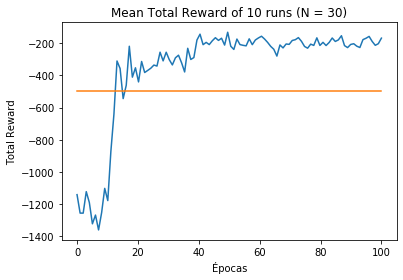

In [33]:
plt.title('Mean Total Reward of 10 runs (N = ' + str(N) + ')')
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.plot(np.linspace(0,episodios,episodios), np.mean(runs_total_reward, axis = 0))
plt.plot(np.linspace(0,episodios,episodios), np.ones(episodios)*-500)

## Exercise 2.4 - answers


**N = 2**

<ins>Training:</ins>
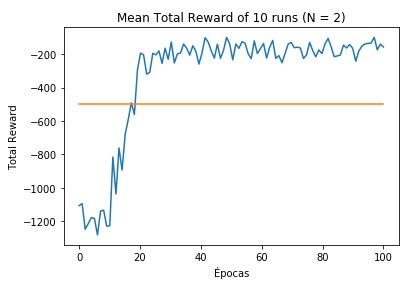
Mean Rise time: 21.5<br>
Mean Computation time: 377.9663388967514<br>
Full Computation Time: 3848.7232739925385<br>
<br>
<ins>Testing:</ins><br>
Mean End Performance: -164.46157783924016<br>


---


**N = 10**

<ins>Training:</ins>
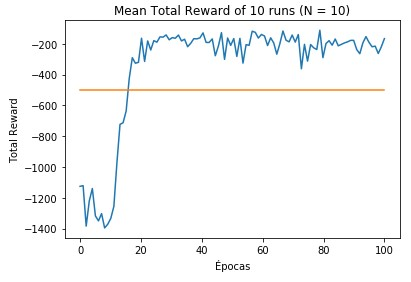
Mean Rise Time: 38.9<br>
Mean Computation time: 529.2493809461594 <br>
Full Computation time: 5382.797513723373 <br>
<br>
<ins>Testing:</ins><br>
Mean End Performance: -216.98882473163167<br>


---


**N = 30**

<ins>Training:</ins>
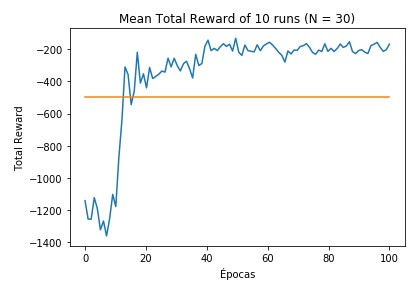
Mean Rise Time: 37.7<br>
Mean Computation time: 771.5681834697723 <br>
Full Computation time: 7804.698663949966 <br>
<br>
<ins>Testing:</ins><br>
Mean End Performance: -192.2360032025395<br>


---


**N = 50**
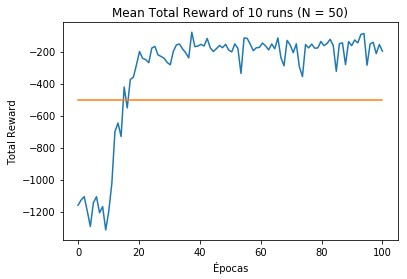
<ins>Training:</ins>

Mean Rise Time: 35.8 <br>
Mean Computation time: 581.454239153862 <br>
Full Computation time:  5881.637989044189<br>
<br>
<ins>Testing:</ins><br>
Mean End Performance: -163.86526506862347<br>


---
---

We observe that with a low N (2, for example) the computing time is considerable lower than with a higher N, but the perfomance does not change that much. So we can say that the computational complexity of this model using more simulated episodes per episode (N) is much bigger. Now, focusing on sample complexity, we observe that, starting the simulated episodes after the 10th real episode, the convergence of the model (rise time) does not change so much, therefore in this case, it would not be better to have more simulated episodes (the sample complexity does not decrease as expected).
Maybe it happens in this specific problem because the pendulum is a simple model to be learned. Probably in more complex models, the performance would increase with higher N's.

When considering the average rise time in 10 runs of training (separately), bigger N provided a slightly bigger rise time. But considering the rise time of the Total Reward means (for each episode) in the same 10 runs, we can observe through the plots that it doensn't have a considerable change.
Maybe this difference over how we measure the rise time has to do with the stochasticity of the method. 

About the end performance, it seems to stay almost the same between runs with different N. The difference we can see is probably due to different inicial values, or due to the stochasticity too. But this difference doesn't mean so much, since all values point to a solved problem (the pendulum could reach the "up" position)

*computation time for N=30 was a lot higher probably because the computar was being used for other purposes at the same time of training

## Exercise 2.5

Both DDPG and the model-based SVAC uses past real experience to learn. The first one uses it to train two networks which are respondible to aproximate the actor (policy) and critic (Value Function). The second, uses it to learn the model of the environment, making it possible to plan ahead of time.

About the performance, we can see that model-based SVAC can converge a lot faster, as long the model is a well generalized one. After start using simulated episodes, it took only a few real episodes to converge to rewards above -500. In terms of end performance, DDPG could get better results, with end performances around -152. The end performance of the model-based version of SVAC was very dependent of how many simulated episodes we used, achieving around -164 as the best end performance with N = 50.

The advantage of using a model-based method is that it generalizes between the individual transitions, making the problem a supervised problem, and therefore, a simpler problem to solve. In other words, model-based algorithms enables the agent to plan ahead. Also, using a model-based method diminishes the need to run real episodes, which is great in cases that deal with objects that may be damaged (e.g. a robot, a car).

On the other hand, model-based learning can be very time-consuming, due to computational complexity (simulating the environment behavior may be an extremely difficult task). Moreover, environments that posseses discontinuities tend to decrease model-based learning successfulness.Also, if the model to be learned is too complex and doens't generalizes well, it will harm the performance of the learning.

Finally, SVAC can not use experience replay because it is an on-policy algorithm. Whenever using an experience replay, we need to use off-policy learning because current parameters are already different to those used to generate the experience replay[1].

1. MNIH, V. et al. **Playing Atari with Deep Reinforcement Learning** (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)